## RNN con California Housing

## Librerías

In [2]:
# Tratamiento de datos
import numpy as np
import pandas as pd

# Visualizaciones
import matplotlib.pyplot as plt
import seaborn as sns

# Modelo de aprendizaje
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error, mean_absolute_percentage_error
from sklearn.datasets import fetch_california_housing



## Descarga y carga de datos

In [3]:
housing = fetch_california_housing()

X = housing.data
y = housing.target

feature_names = housing.feature_names

## Crear un DF

In [4]:
df = pd.DataFrame(X, columns=feature_names)

df['Price'] = y

## Primera Exploración

In [5]:
print(f"Tamaño de el dataset {df.shape}")
print("\nInformacion de las columnas:")
print(df.info())
print("\nEstadísticas descriptivas")
print(df.describe())

Tamaño de el dataset (20640, 9)

Informacion de las columnas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   Price       20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB
None

Estadísticas descriptivas
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.4

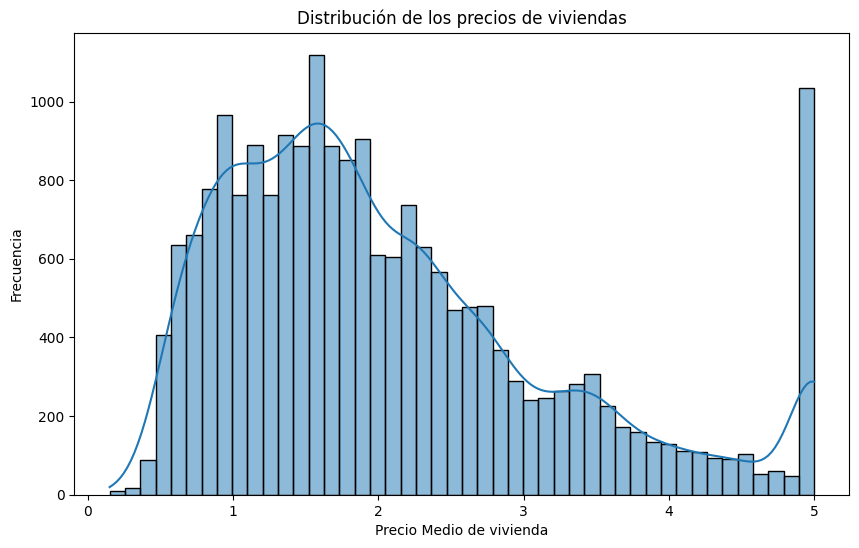

In [6]:
# Visualización de la distribución de precios
plt.figure(figsize=(10,6))
sns.histplot(df['Price'], kde=True);
plt.title('Distribución de los precios de viviendas')
plt.xlabel('Precio Medio de vivienda')
plt.ylabel('Frecuencia');

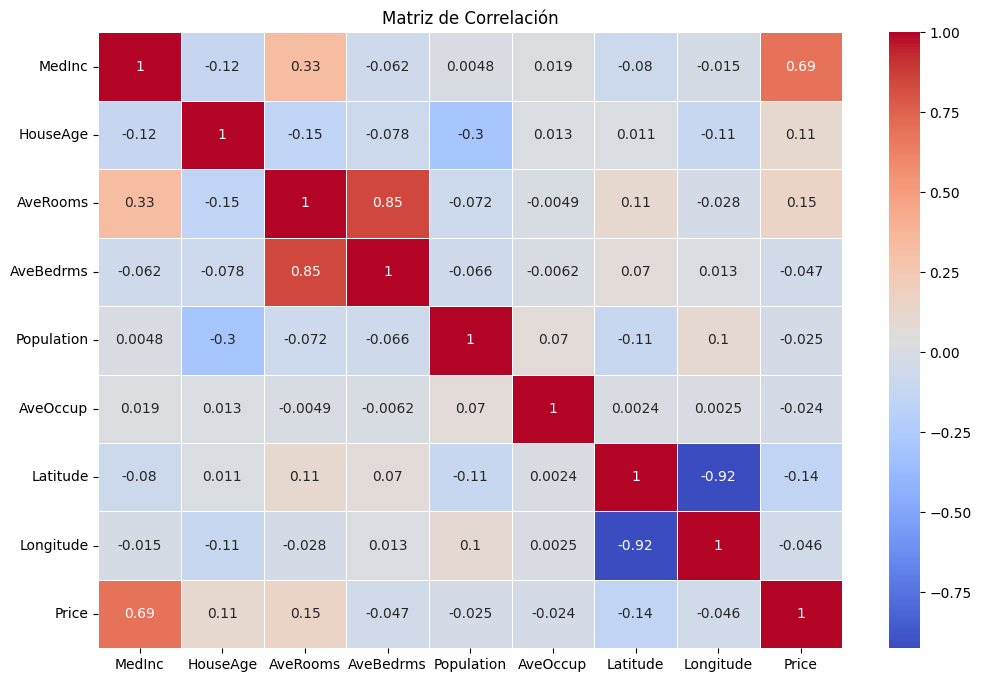

In [7]:
# Matriz de correlación
plt.figure(figsize=(12,8))
correlacion_matrix = df.corr()
sns.heatmap(correlacion_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Matriz de Correlación");

In [ ]:
# Visualizaciones de relaciones entre feature y Price

for feature in feature_names:
    plt.figure(figsize=(10,6))
    sns.scatterplot(x=df[feature], y=df['Price'], alpha=0.1)
    plt.title(f"Relación entre {feature} y Precio Medio de vivienda")
    plt.xlabel(feature)
    plt.ylabel('Precio')
    plt.show();

## Preprocess de los datos

In [ ]:
# Dividir en Train y Test
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=73)

# Escalado de datos

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Construir el Modelo

In [ ]:
def build_model(input_shape, learning_rate=0.001):

    model = keras.Sequential(
        [
            layers.Dense(128, activation='relu', input_shape=(input_shape,)),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            layers.Dense(64, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            layers.Dense(32, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.2),
            layers.Dense(16, activation='relu'),
            layers.Dense(1)
        ]
    )

    optimizador = keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizador,
        loss='mse',
        metrics=['mae']
    )

    return model

In [ ]:
model = build_model(input_shape= X_train_scaled.shape[1])
model.summary()

In [ ]:
# Callback de entrenamiento

early_stopping = keras.callbacks.EarlyStopping(
    patience=30,
    min_delta=0.001,
    restore_best_weights=True,
    monitor='val_loss'
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    factor=0.2,
    patience=10,
    min_lr=0.00001,
    monitor='val_loss'
)

In [ ]:
# Entrenar el Modelo

history = model.fit(
    X_train_scaled,
    y_train,
    validation_split=0.2,
    epochs = 300,
    batch_size = 32,
    callbacks=[early_stopping, reduce_lr]
)

In [ ]:
model.evaluate(X_test_scaled,y_test, verbose=0)
y_pred = model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
R2 = r2_score(y_test, y_pred)

print(f"Test Mean Squared Error (MSE): {mse:.4f}")
print(f"Test Root Mean Squared Error (RMSE): {rmse*100_000:.4f}")
print(f"Test Mean Absolute Percentage Error (MAPE): {mape:.4f}")
print(f"Test Mean Absolute Error (MAE): {mae:.4f}")
print(f"Test R-squared: {R2:.4f}")

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'],label='Entrenamiento')
plt.plot(history.history['val_loss'],label='Validación')
plt.title('Pérdida (loss) durante el entrenamiento')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend();

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'],label='Entrenamiento')
plt.plot(history.history['val_mae'],label='Validación')
plt.title('MAE durante el entrenamiento')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend();

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(y_test,y_pred,alpha=0.3)
plt.plot([y_test.min(),y_test.max()],[y_pred.min(),y_pred.max()], color='r')
plt.xlabel('Precios reales ($100.000)')
plt.xlabel('Predicciones ($100.000)')
plt.title('Predicciones vs Valores Reales')
plt.grid(True)
plt.show();

In [ ]:
residuos = y_test - y_pred.flatten()

plt.figure(figsize=(10,6))

plt.scatter(y_pred, residuos, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--')

plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos')
plt.grid(True)
plt.show();

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(residuos,kde=True)
plt.title('Distribución de Residuos')
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show();

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=73)
rf_model.fit(X_train_scaled, y_train)

importances = rf_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Importancia Relativa')
plt.title('Importancia de las características')
plt.tight_layout()
plt.show();

In [ ]:
# Ejemplo de implementación con Keras Tuner
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

def build_model_tuner(hp):
    model = keras.Sequential()

    # Primera capa densa con número de unidades variable
    model.add(layers.Dense(
        units=hp.Int('units_1', min_value=32, max_value=256, step=32),
        activation='relu',
        input_shape=(X_train.shape[1],)
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))

    # Capas ocultas adicionales (número variable)
    for i in range(hp.Int('num_layers', 1, 4)):
        model.add(layers.Dense(
            units=hp.Int(f'units_{i+2}', min_value=16, max_value=128, step=16),
            activation='relu'
        ))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(hp.Float(f'dropout_{i+2}', min_value=0.1, max_value=0.5, step=0.1)))

    # Capa de salida
    model.add(layers.Dense(1))

    # Compilar el modelo
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
        ),
        loss='mse',
        metrics=['mae']
    )

    return model

# Configurar la búsqueda
tuner = RandomSearch(
    build_model_tuner,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='housing_tuning',
    project_name='california_housing'
)

# Ejecutar la búsqueda
tuner.search(
    X_train_scaled, y_train,
    epochs=50,
    validation_split=0.2,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    ]
)

# Obtener el mejor modelo
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Mejores hiperparámetros: {best_hyperparameters.values}")